In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
import json
import matplotlib.pyplot as plt
%matplotlib inline

#### Loading the Lending Club dataset

In [2]:
loans = pd.read_csv(r"D:\Classification\Project 6\data\lending-club-data.csv")

C:\Users\Govind\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Exploring some features

In [3]:
loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


In [4]:
loans.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

#### Modifying the target column

In [5]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
del loans['bad_loans']

In [6]:
('safe_loans' in loans.columns) and ('bad_loans' not in loans.columns)

True

#### Selecting features

In [7]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies
             'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]
loans = loans[[target]+features]

In [8]:
loans.head()

,safe_loans,grade,sub_grade_num,short_emp,emp_length_num,home_ownership,dti,purpose,payment_inc_ratio,delinq_2yrs,...,pub_rec,pub_rec_zero,revol_util,total_rec_late_fee,int_rate,total_rec_int,annual_inc,funded_amnt,funded_amnt_inv,installment
0,1,B,0.4,0,11,RENT,27.65,credit_card,8.14350,0.0,...,0.0,1.0,83.7,0.00,10.65,861.07,24000.0,5000,4975,162.87
1,-1,C,0.8,1,1,RENT,1.00,car,2.39320,0.0,...,0.0,1.0,9.4,0.00,15.27,435.17,30000.0,2500,2500,59.83
2,1,C,1.0,0,11,RENT,8.72,small_business,8.25955,0.0,...,0.0,1.0,98.5,0.00,15.96,603.65,12252.0,2400,2400,84.33
3,1,C,0.2,0,11,RENT,20.00,other,8.27585,0.0,...,0.0,1.0,21.0,16.97,13.49,2209.33,49200.0,10000,10000,339.31
4,1,A,0.8,0,4,RENT,11.20,wedding,5.21533,0.0,...,0.0,1.0,28.3,0.00,7.90,631.38,36000.0,5000,5000,156.46


In [9]:
loans.columns

Index(['safe_loans', 'grade', 'sub_grade_num', 'short_emp', 'emp_length_num',
       'home_ownership', 'dti', 'purpose', 'payment_inc_ratio', 'delinq_2yrs',
       'delinq_2yrs_zero', 'inq_last_6mths', 'last_delinq_none',
       'last_major_derog_none', 'open_acc', 'pub_rec', 'pub_rec_zero',
       'revol_util', 'total_rec_late_fee', 'int_rate', 'total_rec_int',
       'annual_inc', 'funded_amnt', 'funded_amnt_inv', 'installment'],
      dtype='object')

#### Skipping observations with missing values

In [10]:
loans=loans.dropna()

In [11]:
loans = pd.get_dummies(loans)

In [12]:
with open(r"D:\Classification\Project 6\data\train-idx.json") as f:
    train_idx=json.load(f)
with open(r"D:\Classification\Project 6\data\validation-idx.json") as f:
    validation_idx=json.load(f)

In [13]:
train_data = loans.iloc[train_idx]
validation_data = loans.iloc[validation_idx]

#### Gradient boosted tree classifier

In [14]:
model_5 = GradientBoostingClassifier(n_estimators=5, max_depth=6)

In [15]:
X = train_data.drop('safe_loans',axis=1)

In [16]:
model_5.fit(X, train_data['safe_loans'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=5, presort='auto',
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

#### Making predictions

In [17]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
22,1,0.2,0,3,29.44,6.30496,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
26,1,0.6,1,1,12.19,13.49520,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
24,-1,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
41,-1,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0


In [18]:
model_5.predict(sample_validation_data.drop('safe_loans',1))

array([ 1,  1, -1,  1], dtype=int64)

In [19]:
print("percentage of the predictions on sample_validation_data model_5 get correct is %f "% (300/4))

percentage of the predictions on sample_validation_data model_5 get correct is 75.000000 


#### Prediction Probabilities (of safe loans)

In [20]:
model_5.predict_proba(sample_validation_data.drop('safe_loans',1))[:,1]

array([0.58357669, 0.53050311, 0.46192208, 0.60408361])

#### Evaluating the model on the validation data

In [21]:
print("accuracy is %f"% model_5.score(validation_data.drop('safe_loans',1), validation_data['safe_loans']))

accuracy is 0.661353


In [22]:
predictions=model_5.predict(validation_data.drop('safe_loans',1))

In [23]:
print("the number of false positives are",sum(predictions>validation_data['safe_loans']))

the number of false positives are 1653


In [24]:
print("the number of false negatives are",sum(predictions<validation_data['safe_loans']))

the number of false negatives are 1491


#### Comparison with decision trees

In the earlier project (project 4), the prediction accuracy of the decision trees was around 0.64. In this project, model_5 has an accuracy of approximately 0.67.

Here, we quantify the benefit of the extra 3% increase in accuracy of model_5 in comparison with a single decision tree from the previous project.

False negatives: Assume a cost of \$10,000 per false negative.

False positives: Assume a cost of \$20,000 per false positive.

In [25]:
cost = 20000*1652+10000*1491
cost

47950000

In the previous project, this cost was \$50,370,000.

So, by improving 3% we are saving \$2,420,000.

2.4 million dollar is a lot of money!

#### Most positive & negative loans

In [26]:
validation_data['predictions'] = model_5.predict_proba(validation_data.drop('safe_loans',1))[:,1]

C:\Users\Govind\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
validation_data.head()

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,predictions
24,-1,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,...,0,0,0,0,0,1,0,0,0,0.461922
41,-1,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0.604084
60,-1,0.4,0,5,12.48,3.57024,0.0,1.0,3.0,1,...,0,0,0,0,0,0,1,0,0,0.479872
93,-1,0.4,0,11,23.18,14.70090,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0.406924
132,-1,0.2,0,3,7.83,11.04860,0.0,1.0,2.0,1,...,0,0,0,0,0,0,0,0,0,0.547199


In [28]:
print("grades of top 5 predicted safe loans")
validation_data[['grade_A','grade_B','grade_C','grade_D','grade_E','grade_F','predictions']].\
                                        sort_values('predictions',ascending=False).head(5)

grades of top 5 predicted safe loans


,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,predictions
8021,1,0,0,0,0,0,0.673059
7271,1,0,0,0,0,0,0.661468
71667,1,0,0,0,0,0,0.661468
72452,1,0,0,0,0,0,0.661468
109114,1,0,0,0,0,0,0.661468


In [29]:
print("grades of top 5 predicted risky loans")
validation_data[['grade_A','grade_B','grade_C','grade_D','grade_E','grade_F','predictions']].\
                                        sort_values('predictions',ascending=True).head(5)

grades of top 5 predicted risky loans


,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,predictions
58794,0,0,1,0,0,0,0.307334
84508,0,0,1,0,0,0,0.307334
27502,0,0,1,0,0,0,0.312806
114781,0,0,0,1,0,0,0.315969
84921,0,0,1,0,0,0,0.315969


#### Effects of adding more trees

In [30]:
model_10 = GradientBoostingClassifier(n_estimators=10, max_depth=6)
model_10.fit(train_data.drop('safe_loans',1), train_data['safe_loans'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [31]:
model_50 = GradientBoostingClassifier(n_estimators=50, max_depth=6)
model_50.fit(train_data.drop('safe_loans',1), train_data['safe_loans'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [32]:
model_100 = GradientBoostingClassifier(n_estimators=100, max_depth=6)
model_100.fit(train_data.drop('safe_loans',1), train_data['safe_loans'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [33]:
model_200 = GradientBoostingClassifier(n_estimators=200, max_depth=6)
model_200.fit(train_data.drop('safe_loans',1), train_data['safe_loans'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [34]:
model_500 = GradientBoostingClassifier(n_estimators=500, max_depth=6)
model_500.fit(train_data.drop('safe_loans',1), train_data['safe_loans'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [35]:
model_10.score(validation_data.drop(['safe_loans','predictions'],1), validation_data['safe_loans'])

0.6664153382162861

In [36]:
model_50.score(validation_data.drop(['safe_loans','predictions'],1), validation_data['safe_loans'])

0.6844032744506678

In [37]:
model_100.score(validation_data.drop(['safe_loans','predictions'],1), validation_data['safe_loans'])

0.6892503231365791

In [38]:
model_200.score(validation_data.drop(['safe_loans','predictions'],1), validation_data['safe_loans'])

0.685803532959931

In [39]:
model_500.score(validation_data.drop(['safe_loans','predictions'],1), validation_data['safe_loans'])

0.6859112451529513

model_10 has the best accuracy on the validation_data

#### Plotting the training and validation error vs. number of trees

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In [41]:
train_err_10 = 1 - model_10.score(train_data.drop('safe_loans',1), train_data['safe_loans'])
train_err_50 = 1 - model_50.score(train_data.drop('safe_loans',1), train_data['safe_loans'])
train_err_100 = 1 - model_100.score(train_data.drop('safe_loans',1), train_data['safe_loans'])
train_err_200 = 1 - model_200.score(train_data.drop('safe_loans',1), train_data['safe_loans'])
train_err_500 = 1 - model_500.score(train_data.drop('safe_loans',1), train_data['safe_loans'])

In [42]:
validation_err_10 = 1 - model_10.score(validation_data.drop(['safe_loans','predictions'],1), validation_data['safe_loans'])
validation_err_50 = 1 - model_50.score(validation_data.drop(['safe_loans','predictions'],1), validation_data['safe_loans'])
validation_err_100 = 1 - model_100.score(validation_data.drop(['safe_loans','predictions'],1), validation_data['safe_loans'])
validation_err_200 = 1 - model_200.score(validation_data.drop(['safe_loans','predictions'],1), validation_data['safe_loans'])
validation_err_500 = 1 - model_500.score(validation_data.drop(['safe_loans','predictions'],1), validation_data['safe_loans'])

In [43]:
training_errors = [train_err_10, train_err_50, train_err_100, train_err_200, train_err_500]

In [44]:
validation_errors = [validation_err_10, validation_err_50, validation_err_100, validation_err_200, validation_err_500]

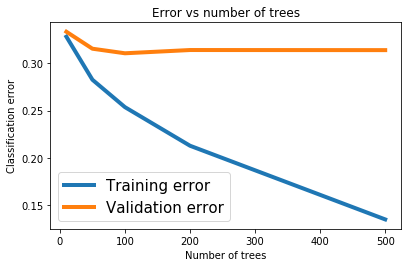

In [45]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')